In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import spatial

import os

In [4]:
from shapely.geometry import Point
from shapely.geometry import Polygon

In [5]:
plt.style.use('Solarize_Light2')   # try another styles: 'classic'

In [6]:
driver = "~/"  # "G:/
destData = os.path.join(driver, "1_Data1/sea/AllSeaGisOut.txt")
batimetrFile = "G:/1_Data1/batimetria/b1.txt"

In [7]:
obris = pd.read_csv(os.path.join(driver, "1_Data1/obris/obris.dat"),
                    header=0,
                    na_values='--',
                    sep='\t',
                    decimal=',',
                   )

In [8]:
obrisEast = pd.read_csv(os.path.join(driver, "1_Data1/obris/obrisEast.dat"),
                        header=0,
                        na_values='--',
                        sep='\t',
                        decimal=',',
                       )

In [9]:
obrisWest = pd.read_csv(os.path.join(driver, "1_Data1/obris/obrisWest.dat"),
                        header=0,
                        na_values='--',
                        sep='\t',
                        decimal=',',
                       )
obrisWest.head(3)

,n,long,lat
0,1,103.709167,51.707917
1,2,103.713056,51.716250
2,3,103.713611,51.718194


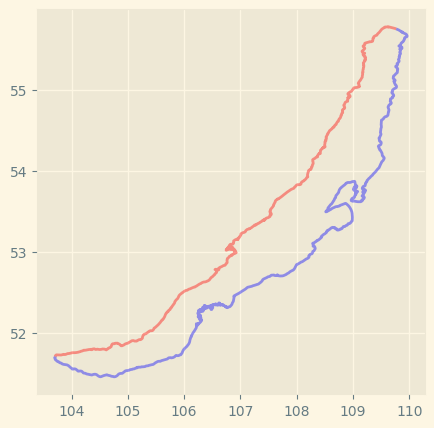

In [11]:
plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
ax.plot(obrisEast['long'], obrisEast['lat'], 'b-', alpha=0.4)
ax.plot(obrisWest['long'], obrisWest['lat'], 'r-', alpha=0.4)


## GIS handlers   
### Get Squared Baikal

In [12]:
def dist(a, b):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees,
    [0] - long,
    [1] - lat)
    """
    x1, y1, x2, y2 = map(np.radians, [a[0], a[1], b[0], b[1]])
    dx = x2 - x1
    dy = y2 - y1
    a = np.sin(dy/2)**2 + np.cos(y1) * np.cos(y2) * np.sin(dx/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # Earth`s radius in kilometers
    km = 6372.795 * c
    return km


def rdist(a, b):
    """
    Calculate the great circle distance between two points
    on the sphere, radius 1 ru (specified in radians, x1, y1, x2, y2
    x - long, y - lat).
    multiply result to Earth`s dia (6372.795 km) to get metric distance on Earth surface
    """
    x1, y1 = a
    x2, y2 =b
    return 2 * np.arcsin(np.sqrt(np.sin((y2 - y1)/2)**2 + np.cos(y1) * np.cos(y2) * np.sin((x2 - x1)/2)**2))

In [15]:
tomsk = (85.1974, 56.372)
moscow = (37.929, 55.422)
a = (35.0456, -85.2672)
b = (35.9728, -83.9422)
dist(a, b)

147.688665474318

In [16]:
nordPoint = (109.767, 55.751)
sudPoint = (103.70917, 51.707917)

In [17]:
obrisWest['longr'] = np.radians(obrisWest['long'])
obrisWest['latr'] = np.radians(obrisWest['lat'])
obrisEast['longr'] = np.radians(obrisEast['long'])
obrisEast['latr'] = np.radians(obrisEast['lat'])

In [21]:
ob = zip(list(obrisWest['long'])+(list(obrisEast['long'])) , list(obrisWest['lat'])+(list(obrisEast['lat'])))
obrisPolygon = Polygon(ob)

In [ ]:
longStep = 0.02
latStep = 0.01

In [ ]:
dist((0, 51.5), (longStep, 51.5)),  dist((0, 55.9), (longStep, 55.9))

(1.384799433804472, 1.2471555145188842)

In [40]:
dist((110, 51.5), (110, 51.5+latStep))

1.112262553046251

In [36]:
dff = 0
dff = pd.DataFrame(columns=['long', 'lat'])

n=0
for x in range(10350, 11000, round(longStep*100)):
    print(f'long = {x/100}; ', end='')
    for y in np.arange(5140, 5590, round(latStep*100)):
        if obrisPolygon.contains(Point(x/100, y/100)):
            toWest = obrisWest.apply(lambda f: dist((f['long'], f['lat']), (x/100, y/100)), axis=1).min()
            toEast = obrisEast.apply(lambda f: dist((f['long'], f['lat']), (x/100, y/100)), axis=1).min()
            toSud = dist(sudPoint, (x/100, y/100))
            toNord = dist(nordPoint, (x/100, y/100))
            dff.loc[len(dff), ['long', 'lat', 'toWest', 'toEast', 'toSud', 'toNord']] = [x/100, y/100, toWest, toEast, toSud, toNord]
            n+=1
            if n%100 == 0:
                print(f"n={n},", end=' ')
print("done!")

long = 103.5; long = 103.52; long = 103.54; long = 103.56; long = 103.58; long = 103.6; long = 103.62; long = 103.64; long = 103.66; long = 103.68; long = 103.7; long = 103.72; long = 103.74; long = 103.76; long = 103.78; long = 103.8; long = 103.82; long = 103.84; long = 103.86; long = 103.88; long = 103.9; long = 103.92; n=100, long = 103.94; long = 103.96; long = 103.98; long = 104.0; long = 104.02; long = 104.04; n=200, long = 104.06; long = 104.08; long = 104.1; long = 104.12; n=300, long = 104.14; long = 104.16; long = 104.18; long = 104.2; n=400, long = 104.22; long = 104.24; long = 104.26; long = 104.28; n=500, long = 104.3; long = 104.32; long = 104.34; n=600, long = 104.36; long = 104.38; long = 104.4; n=700, long = 104.42; long = 104.44; long = 104.46; n=800, long = 104.48; long = 104.5; long = 104.52; n=900, long = 104.54; long = 104.56; long = 104.58; n=1000, long = 104.6; long = 104.62; long = 104.64; long = 104.66; n=1100, long = 104.68; long = 104.7; n=1200, long = 104.

In [35]:
dff.loc[0,['long']]

long    103.72
Name: 0, dtype: object

In [41]:
dff.to_csv('wholeBaikalGrid.dat',
          sep='\t')

In [26]:
dff

,long,lat,toWest,toEast,toSud,toNord
0,103.9,51.7,3.692319,10.050579,13.183287,592.95445
1,104.1,51.6,17.38168,5.600282,29.519998,593.382115
2,104.1,51.7,6.397597,15.810201,26.954139,584.502688
3,104.3,51.5,31.457257,1.252625,46.911654,594.270997
4,104.3,51.6,20.900468,11.655669,42.500773,585.21237
...,...,...,...,...,...,...
210,109.7,55.3,31.197587,3.929215,562.376812,50.340077
211,109.7,55.4,29.989708,7.346168,569.99098,39.267057
212,109.7,55.5,24.773557,8.127559,577.718648,28.233061
213,109.7,55.6,17.309022,9.765515,585.555321,17.312864


In [ ]:
plt.scatter('norm_x', 'norm_xx', data=res, s=5, alpha=0.2)

In [ ]:
# This solution by @denis is OK for small xy2
res = pd.DataFrame(columns=['long', 'lat'])

res['mindistWest'] = np.min(spatial.distance.cdist(res.loc[:, ['rlong', 'rlat']], obrisWest.loc[:, ['rlong', 'rlat']], metric=rdist), axis=1)
res['mindistEast'] = np.min(spatial.distance.cdist(res.loc[:, ['rlong', 'rlat']], obrisEast.loc[:, ['rlong', 'rlat']], metric=rdist), axis=1)
res['norm_x'] = res['mindistWest']/(res['mindistWest'] + res['mindistEast'])
res['toNord'] = np.min(spatial.distance.pdist(res.loc[:, ['rlong', 'rlat']], obrisWest.loc[:, ['rlong', 'rlat']], metric=rdist), axis=1)
res['mindistEast'] = np.min(spatial.distance.cdist(res.loc[:, ['rlong', 'rlat']], obrisEast.loc[:, ['rlong', 'rlat']], metric=rdist), axis=1)

res['norm_y'] = res['toSud']/(res['toSud'] + res['toNord'])

res

In [ ]:
l = list(obrisWest['long']) + list(obrisEast['long'])

In [ ]:
point = Point(103, 55)

In [ ]:
obrisPolygon.contains(point)

In [ ]:
dff = pd.DataFrame(columns=['long', 'lat'])
dff

#### fill baikal obris with cells `longStep` * `latStep`  
do it once. do no forget save to file

In [ ]:
dff['norm_x'] = np.int32(dff['toWest']/(dff['toWest'] + dff['toEast'])*100)
dff['norm_y'] = np.int32(dff['toSud']/(dff['toSud'] + dff['toNord'])*100)
dff

In [ ]:
dff.plot('long', 'lat', c=dff['norm_x'], kind='scatter',)